In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

In [12]:
directory = os.path.join("HRRPY180","HRRYIG_BJ_PY")
files = [f for f in os.listdir(directory) if f.endswith('.csv')]

print(files)

['0001.csv', '0002.csv', '0003.csv', '0004.csv', '0005.csv', '0006.csv', '0007.csv', '0008.csv', '0009.csv', '0010.csv', '0011.csv', '0012.csv', '0013.csv', '0014.csv', '0015.csv', '0016.csv', '0017.csv', '0018.csv', '0019.csv', '0020.csv', '0021.csv', '0022.csv', '0023.csv', '0024.csv', '0025.csv', '0026.csv', '0027.csv', '0028.csv', '0029.csv', '0030.csv', '0031.csv', '0032.csv', '0033.csv', '0034.csv', '0035.csv', '0036.csv', '0037.csv', '0038.csv', '0039.csv', '0040.csv', '0041.csv', '0042.csv', '0043.csv', '0044.csv', '0045.csv', '0046.csv', '0047.csv', '0048.csv', '0049.csv', '0050.csv', '0051.csv', '0052.csv', '0053.csv', '0054.csv', '0055.csv', '0056.csv', '0057.csv', '0058.csv', '0059.csv', '0060.csv', '0061.csv', '0062.csv', '0063.csv', '0064.csv', '0065.csv', '0066.csv', '0067.csv', '0068.csv', '0069.csv', '0070.csv', '0071.csv', '0072.csv', '0073.csv', '0074.csv', '0075.csv', '0076.csv', '0077.csv', '0078.csv', '0079.csv', '0080.csv', '0081.csv', '0082.csv', '0083.csv', '00

In [13]:
data = pd.read_csv(os.path.join(directory, files[0]), header=0, index_col=0)

data

,S11_Real,S11_Imaginary,S21_Real,S21_Imaginary,S12_Real,S12_Imaginary,S22_Real,S22_Imaginary
Frequency (Hz),,,,,,,,
1.000000e+09,-0.088801,0.058075,-0.671542,-0.732591,-0.667666,-0.728937,-0.084132,0.062353
1.002969e+09,-0.087833,0.057936,-0.676688,-0.727969,-0.672790,-0.724352,-0.082850,0.062374
1.005938e+09,-0.086849,0.057872,-0.681789,-0.723310,-0.677812,-0.719652,-0.081491,0.062530
1.008906e+09,-0.085851,0.057914,-0.686814,-0.718565,-0.682843,-0.714964,-0.080091,0.062812
1.011875e+09,-0.084869,0.058061,-0.691793,-0.713829,-0.687803,-0.710242,-0.078648,0.063230
...,...,...,...,...,...,...,...,...
1.998812e+10,0.462402,0.682730,0.043191,0.037492,0.042072,0.037994,0.513915,0.228768
1.999109e+10,0.464885,0.679224,0.043137,0.037419,0.042060,0.037969,0.516584,0.222241
1.999406e+10,0.467436,0.676199,0.043036,0.037267,0.041905,0.037741,0.519080,0.215892


In [14]:
current = np.arange(0,7.04,0.02)
field = 1.61893 + 26.1952 * current # length of field is number of files

In [15]:
print(data.S21_Real.to_numpy())
print(data.index.to_numpy()*1e-9) # in GHz

[-0.67154217 -0.67668765 -0.68178866 ...  0.04303567  0.04279814
  0.0426066 ]
[ 1.          1.00296875  1.0059375  ... 19.9940625  19.99703125
 20.        ]


In [16]:
data.keys()

Index(['S11_Real', 'S11_Imaginary', 'S21_Real', 'S21_Imaginary', 'S12_Real',
       'S12_Imaginary', 'S22_Real', 'S22_Imaginary'],
      dtype='object')

In [17]:
s_parameters = dict()

for file in files:
    data = pd.read_csv(os.path.join(directory, file), header=0, index_col=0)
    for key in data.keys():
        if key not in s_parameters:
            s_parameters[key] = np.empty((len(files), len(data)))
        s_parameters[key][files.index(file), :] = data[key].to_numpy()

In [18]:
def s_param_plot(key):
    plot_data = s_parameters[f'{key}_Real']+1j*s_parameters[f'{key}_Imaginary']
    plt.pcolormesh(field,data.index*1e-9,np.abs(plot_data).T)
    plt.ylabel("Freq (GHz)")
    plt.xlabel("Field")
    plt.title(f"{key} Parameter Magnitude")
    plt.tight_layout()
    plt.colorbar()
    plt.show()

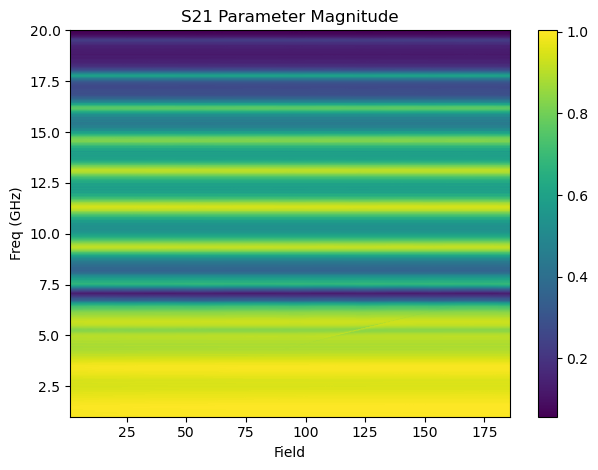

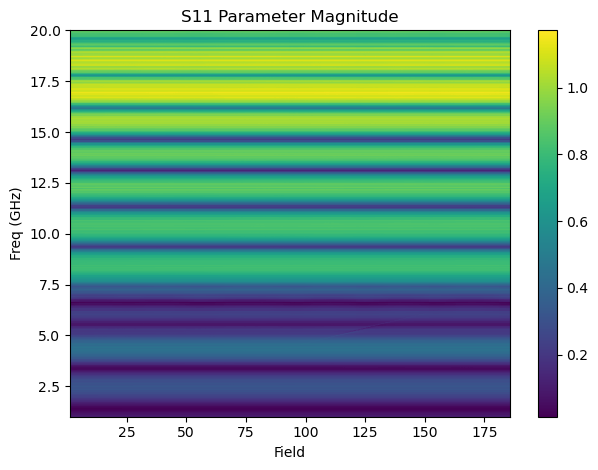

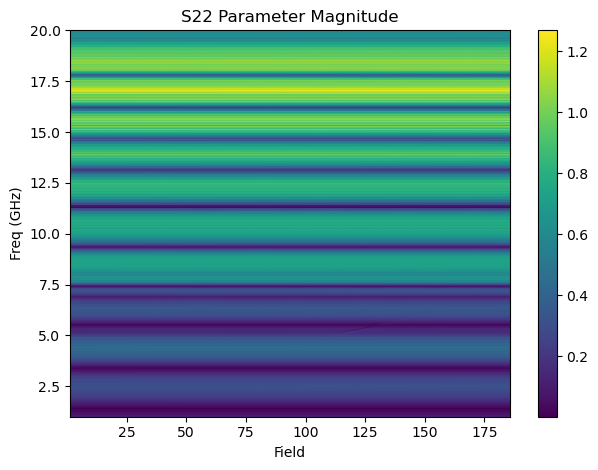

In [19]:
s_param_plot('S21')
s_param_plot('S11')
s_param_plot('S22')